In [97]:
show_plots = False;
debug_plots = False;
debug_plots_back = False;
contact_detection = False;

In [1]:
import time
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from pathlib import Path
from numpy.core.numeric import empty_like
from pydicom import dcmread
import functools
import csv
from skimage import data, filters, color
from skimage.segmentation import flood, flood_fill
from skimage.filters import gaussian
import cv2
from sklearn.cluster import KMeans
from skimage.morphology import medial_axis, skeletonize, thin
from skimage.util import invert
import scipy.ndimage as ndi
import math
import warnings

from shapely.geometry import Polygon
import alphashape
from shapely import geometry, ops

import SimpleITK as sitk
import pandas as pd

In [2519]:
def bounding_box(points):

    x_coordinates, y_coordinates = points

    width = max(x_coordinates) - min(x_coordinates)
    height = max(y_coordinates) - min(y_coordinates)

    x_center = (width/2) + min(x_coordinates)
    y_center = (height/2) + min(y_coordinates)
    box_center = [x_center, y_center]
    return width, height, box_center

def get_clusters(X,y):
    s = np.argsort(y)
    return np.split(X[s], np.unique(y[s], return_index=True)[1][1:])

def hull_and_kmeans(data_object):
    # data = np.array(data_object, dtype=np.uint16)
    #
    # arr2 = np.array(data, dtype=np.uint8)
    #
    # arr2_binary_all = cv2.adaptiveThreshold(arr2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, -2)
    # th = (arr2.max() - arr2.min())/2 + dat.min()
    # _, arr2_binary_thresh = cv2.threshold(arr2, 130, 255, cv2.THRESH_BINARY)
    # arr2_binary_all = arr2_binary_all | arr2_binary_thresh

    # mask = remove_background(arr2_binary_all)
    # mask = remove_background(data_object)
    arr2_binary = data_object.astype('uint8')
    # threshold to binarize image

    # find contours
    image_points = np.where(arr2_binary > 120)
    shape_pts = []

    for idx in range(image_points[0].shape[0]):
        shape_pts.append((image_points[1][idx], image_points[0][idx]))

    alpha_shape_total = alphashape.alphashape(shape_pts, 1/4)
    points = []
    if alpha_shape_total.geom_type != 'Polygon':
        for polygon in list(alpha_shape_total.geoms):
            points.extend(polygon.exterior.coords[:-1])
    else:
        points.extend(alpha_shape_total.exterior.coords[:-1])

    hull_arr2 = []

    if len(points) < 1:
        return arr2_binary

    arr = [[np.asarray(points[0], dtype="int32")]]
    for point in points:
        arr = np.append(arr, [[np.asarray(point,dtype="int32")]], axis=0)

    hull_arr2.append(arr)
    hull_arr2 = np.asarray(hull_arr2)

    cv2.drawContours(arr2_binary, hull_arr2, -1, (254, 0, 0), 1)

    return arr2_binary

def loop(arr2, area_prev, arr_prev_flooded, arr_prev_plane):
    upper_limit = 120
    box_points_prev = np.where(arr_prev_plane == 1)
    width_prev, height_prev, box_center_prev = bounding_box(box_points_prev)

    arr2_flooded = np.zeros_like(arr2) == 1
    #loop through all x and y spots and compare back to the previous z to see hwere they overlay
    flag = False
    for x in range(np.size(arr2, 0)):
        for z in range(np.size(arr2, 1)):
            #to account for slightly lighter pixels

            tol = upper_limit - np.ceil(arr2[x, z])
            if arr_prev_flooded[x, z] == 1 and arr2_flooded[x, z] == 0 and (arr2[x,z]<upper_limit):  # or np.any(arr_prev_flooded[x-1:x+1, z-1:z+1]))
                #floodfill at that x, y and don't save

                arr2_forflood = arr2.copy()
                arr2_forflood[arr2_forflood < arr2[x,z]] = arr2[x,z]

                arr_flooded_temp = flood_fill(arr2_forflood, (x, z), 1, connectivity = 1, tolerance = tol)
                arr_flooded_temp = arr_flooded_temp == 1

                #pass the new floodfill back to the arr2 fill
                check_area = arr2_flooded | arr_flooded_temp

                check_area_prev = check_area | arr_prev_plane
                #find contours for check_area
                box_points = np.where(check_area_prev == 1)
                width, height, box_center = bounding_box(box_points)


                #should this checked area be added?

                # area_truth = (sum(sum(check_area))) <(area_percent*area_prev) or sum(sum(check_area)) < 25
                area_truth = (sum(sum(check_area))) <(area_percent*area_prev) or sum(sum(check_area)) < 50

                acceptable_box_change = (width < crop*.6 and height < crop*.6) and (((((width-width_prev)/width_prev) < 1.5 and (height-height_prev)/height_prev<0.66)) or (((width-width_prev)/width_prev <1.5 and (height-height_prev)/height_prev) < 0.66))
                # acceptable_box_change = (width/width_prev < 3 and height/height_prev<3 and width < 15 and height < 15)


                #print(f"Checked area is {sum(sum(check_area))} and allowable change is {(area_percent*area_prev)}")
                if area_truth: #and acceptable_box_change: #((-0.09*area_prev)+3) * area_prev:
                    arr2_flooded = arr2_flooded | arr_flooded_temp

                elif not area_truth: #if (sum(sum(check_area.astype(int),1))) > 0.25 *(crop_size**2):

                    flag = True
                else:
                    print(f"Issue is the box change")




    arr2_area = sum(sum(arr2_flooded.astype(int)))

    if arr2_area > 0:
        width_curr, height_curr, _ = bounding_box(np.where(arr2_flooded == 1))
        if (width_curr < width_prev * .1 and height_curr < height_prev * .1):
            arr2_flooded = np.zeros_like(arr2) == 1
            print("Box became too small")
            arr2_area = sum(sum(arr2_flooded.astype(int)))

    print(f"Calculated area for next loop is {arr2_area}")
    return arr2_flooded, flag


def remove_background(arr_binary, curr_flood=None):
    connectivity = 4
    output = cv2.connectedComponentsWithStats(arr_binary, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    mask = np.zeros(arr_binary.shape, dtype="uint8")

    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        keepWidth = w>5 and w<50
        keepHeight = h>5 and h <65
        keepArea = area>30 and area < 1500
        keepX = (x+(w/2)) >5 and (x+(w/2))<35
        keepY = (y+(h/2)) > 5 and (y+(h/2))<35
        if curr_flood is None:
            keepCloseToSeg = True
        else:
            keepCloseToSeg = np.sum((cv2.dilate(np.asarray(curr_flood*255, dtype="uint8"), np.ones((4,4))) > 0) * (labels == i)) > 0

        if all((keepWidth, keepHeight, keepArea, keepX, keepY, keepCloseToSeg)):
            #print("[INFO] keeping connected component '{}'".format(i))
            componentMask = (labels == i).astype("uint8") * 255
            mask = cv2.bitwise_or(mask, componentMask)
        #else:
        #print("[INFO] not keeping connected component '{}'".format(i))

    return mask

#function to move forward
def press_forward_y(arr_prev_flooded, y, area_prev):


    arr2_og = crop_scan[:, y+1, :]
    #pull out the  coronal plane
    arr2_og = np.array(arr2_og, dtype=np.uint16)
    #convert data types

    arr2_blurred = cv2.GaussianBlur(arr2_og, (3,3), 0)

    dat = np.array(arr2_blurred, dtype = np.uint8) #can switch to arr2_blurred or arr2_og
    #scale to uint8

    #loop through all x and y spots and compare back to the previous z to see hwere they overlay
    arr2_flooded = np.zeros_like(arr2_og) == 1

    # th1 = (dat.max() - dat.min())/3 + dat.min()
    # th2 = (dat.max() - dat.min())/3*2 + dat.min()

    # dat2 = dat.copy()
    # dat2[dat2 > th2] = th2
    # dat2[dat2 < th1] = th1

    arr2_binary = cv2.adaptiveThreshold(dat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    centerPix = dat[int(np.round(np.sum(np.sum(arr_prev_flooded,axis=1) * np.arange(arr_prev_flooded.shape[0])) / np.sum(arr_prev_flooded))), \
                    int(np.round(np.sum(np.sum(arr_prev_flooded,axis=0) * np.arange(arr_prev_flooded.shape[1])) / np.sum(arr_prev_flooded)))]
    th = (np.percentile(dat.flatten(),95) - centerPix)/3 + centerPix
    _, arr2_binary_thresh = cv2.threshold(dat, th, 255, cv2.THRESH_BINARY)
    arr2_binary = remove_background(arr2_binary | arr2_binary_thresh, arr_prev_flooded)

    # plt.imshow(arr2_binary)
    # plt.show()

    # out, flag = loop(arr2_og, area_prev, arr_prev_flooded, arr_prev_flooded)
    out, flag = loop(arr2_binary, area_prev, arr_prev_flooded, arr_prev_flooded)

    arr2_flooded = arr2_flooded | out
    arr2_area = sum(sum(arr2_flooded.astype(int)))
    arr4_flooded = arr2_flooded.copy()
    arr4_area = sum(sum(arr4_flooded))
    if flag == True:
        print(f"Original area size is {arr2_area}")
        arr2_flooded = np.zeros_like(arr2_og) == 1
        if debug_plots:
            print('arr2_og')
            plt.imshow(arr2_og)
            plt.show();

        arr2 = hull_and_kmeans(arr2_binary)

        if debug_plots:
            print('arr2')
            plt.imshow(arr2)
            plt.show();

        #cv2.waitKey(0)
        out, flag = loop(arr2, area_prev, arr_prev_flooded, arr_prev_flooded)
        arr2_flooded = out | arr2_flooded

        arr2_old = arr2_flooded.copy();
        tmp = np.zeros((crop, crop));

        seg_mean = np.mean(arr2_og[arr2_flooded])
        seg_sd = np.std(arr2_og[arr2_flooded])

        for i in range(arr2_flooded.shape[0]):
            for j in range(arr2_flooded.shape[1]):
                if arr2_old[i,j] == True:
                    if i > 0 and arr2[i-1,j] == 254 and arr2_og[i-1,j] - seg_mean < seg_sd:
                        tmp[i-1,j] = tmp[i-1,j] + 1;
                    if j > 0 and arr2[i,j-1] == 254 and arr2_og[i,j-1] - seg_mean < seg_sd:
                        tmp[i,j-1] = tmp[i,j-1] + 1;
                    if i < arr2_flooded.shape[0]-1 and arr2[i+1,j] == 254 and arr2_og[i+1,j] - seg_mean < seg_sd:
                        tmp[i+1,j] = tmp[i+1,j] + 1;
                    if j < arr2_flooded.shape[1]-1 and arr2[i,j+1] == 254 and arr2_og[i,j+1] - seg_mean < seg_sd:
                        tmp[i,j+1] = tmp[i,j+1] + 1;
                    if i > 0 and j > 0 and arr2[i-1,j-1] == 254 and arr2_og[i-1,j-1] - seg_mean < seg_sd:
                        tmp[i-1,j-1] = tmp[i-1,j-1] + 1;
                    if i > 0 and j < arr2_flooded.shape[1]-1 and arr2[i-1,j+1] == 254 and arr2_og[i-1,j+1] - seg_mean < seg_sd:
                        tmp[i-1,j+1] = tmp[i-1,j+1] + 1;
                    if i < arr2_flooded.shape[0]-1 and j > 0 and arr2[i+1,j-1] == 254 and arr2_og[i+1,j-1] - seg_mean < seg_sd:
                        tmp[i+1,j-1] = tmp[i+1,j-1] + 1;
                    if  i < arr2_flooded.shape[0]-1 and j < arr2_flooded.shape[1]-1 and arr2[i+1,j+1] == 254 and arr2_og[i+1,j+1] - seg_mean < seg_sd:
                        tmp[i+1,j+1] = tmp[i+1,j+1] + 1;
        arr2_flooded = arr2_flooded | (tmp > 3);

        if debug_plots:
            print('tmp');
            plt.imshow(tmp);
            plt.show();
            print('arr2_flooded')
            plt.imshow(arr2_flooded)
            plt.show();

        arr3_binary_all = cv2.adaptiveThreshold(dat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
        _, arr3_binary_thresh = cv2.threshold(dat, 130, 255, cv2.THRESH_BINARY)
        arr3_binary_all = arr3_binary_all | arr3_binary_thresh

        if debug_plots:
            print('arr3_binary')
            plt.imshow(arr3_binary_all)
            plt.show();

        #create the new binary
        mask = remove_background(arr3_binary_all, arr_prev_flooded)
        arr3 = mask.astype('uint8')

        if debug_plots:
            print('arr3')
            plt.imshow(arr3)
            plt.show();

        arr3[arr2_flooded] = 254
        #plt.imshow(arr3)

        if debug_plots:
            print('arr3 post')
            plt.imshow(arr3)
            plt.show();

        #arr_to_dilate = cv2.threshold(np.asarray(arr1_flooded*255), 50, 255, cv2.THRESH_BINARY)
        arr2_dilated = cv2.dilate(np.asarray(arr2_flooded*255, dtype="uint8"), np.ones((3,3)))
        #plt.imshow(arr3)

        out, flag = loop(arr3, area_prev, arr2_dilated == 255, arr_prev_flooded)
        check_arr2_flooded = out | arr2_flooded

        if debug_plots:
            print('check_arr2_flooded')
            plt.imshow(check_arr2_flooded)
            plt.show();

        if sum(sum(check_arr2_flooded)) < area_percent*area_prev:
            print(f"Filled in the gaps with area {sum(sum(check_arr2_flooded))} and allowable change is {area_percent*area_prev} at {y+1}")
            arr2_flooded = out | arr2_flooded
        else:
            print(f"Did not fill in the gaps with area {sum(sum(check_arr2_flooded))} and allowable change is {area_percent*area_prev} at {y+1}")


    arr2_area = sum(sum(arr2_flooded.astype(int)))
    print(f"[FORWARD] Calculated area for next forwards step is {arr2_area}")

    if debug_plots:
        print('arr4_flooded')
        plt.imshow(arr4_flooded)
        plt.show();

    if (arr2_area < area_percent * area_prev or arr2_area < 100) and arr2_area < 200 and y + 2 < crop and arr2_area > 2: #and count <= 3:
        segmentation_y[:, y+1, :] = arr2_flooded.astype(int)
        press_forward_y(arr2_flooded, y+1, arr2_area)
    # elif (arr4_area < area_percent * area_prev or arr4_area < 25) and y + 2 <= crop and arr4_area > 0:
    #     segmentation_y[:, y+1, :] = arr4_flooded.astype(int)
    #     print("Im in arr4 forward")
    #     press_forward_y(arr4_flooded, y+1, arr4_area)
    else:
        print(f"[FORWARD] Stopping forward movement at {y+1} and area is {arr2_area}")


def press_backward_y(arr_prev_flooded, y, area_prev):
    #pull out the next array

    arr2_og = crop_scan[:, y-1, :]
    #pull out the  coronal plane
    arr2_og = np.array(arr2_og, dtype=np.uint16)
    #convert data types

    arr2_blurred = cv2.GaussianBlur(arr2_og, (3,3), 0)

    dat = np.array(arr2_blurred, dtype = np.uint8) #can switch to arr2_blurred or arr2_og
    #scale to uint8

    #loop through all x and y spots and compare back to the previous z to see hwere they overlay
    arr2_flooded = np.zeros_like(arr2_og) == 1

    # th1 = (dat.max() - dat.min())/3 + dat.min()
    # th2 = (dat.max() - dat.min())/3*2 + dat.min()

    # dat2 = dat.copy()
    # dat2[dat2 > th2] = th2
    # dat2[dat2 < th1] = th1

    arr2_binary = cv2.adaptiveThreshold(dat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    centerPix = dat[int(np.round(np.sum(np.sum(arr_prev_flooded,axis=1) * np.arange(arr_prev_flooded.shape[0])) / np.sum(arr_prev_flooded))),\
                    int(np.round(np.sum(np.sum(arr_prev_flooded,axis=0) * np.arange(arr_prev_flooded.shape[1])) / np.sum(arr_prev_flooded)))]
    th = (np.percentile(dat.flatten(),95) - centerPix)/3 + centerPix
    _, arr2_binary_thresh = cv2.threshold(dat, th, 255, cv2.THRESH_BINARY)
    arr2_binary = remove_background(arr2_binary | arr2_binary_thresh, arr_prev_flooded)

    # plt.imshow(arr2_binary)
    # plt.show()

    # out, flag = loop(arr2_og, area_prev, arr_prev_flooded, arr_prev_flooded)
    out, flag = loop(arr2_binary, area_prev, arr_prev_flooded, arr_prev_flooded)

    arr2_flooded = arr2_flooded | out
    arr2_area = sum(sum(arr2_flooded.astype(int)))

    arr4_flooded = arr2_flooded.copy()
    arr4_area = sum(sum(arr4_flooded))

    if flag == True:
        print(f"Original area size is {arr2_area}")
        arr2_flooded = np.zeros_like(arr2_og) == 1

        if debug_plots or debug_plots_back:
            print('arr2_og')
            plt.imshow(arr2_og)
            plt.show();

        arr2 = hull_and_kmeans(arr2_binary)
        # cv2.imshow('new arr', arr2)

        if debug_plots or debug_plots_back:
            print('arr2')
            plt.imshow(arr2)
            plt.show();

        #cv2.waitKey(0)
        out, flag = loop(arr2, area_prev, arr_prev_flooded, arr_prev_flooded)
        arr2_flooded = out | arr2_flooded

        if debug_plots or debug_plots_back:
            print('arr2_flooded')
            plt.imshow(arr2_flooded)
            plt.show();

        arr2_old = arr2_flooded.copy();
        tmp = np.zeros((crop,crop));

        seg_mean = np.mean(arr2_og[arr2_flooded])
        seg_sd = np.std(arr2_og[arr2_flooded])

        for i in range(arr2_flooded.shape[0]):
            for j in range(arr2_flooded.shape[1]):
                if arr2_old[i,j] == True:
                    if i > 0 and arr2[i-1,j] == 254 and arr2_og[i-1,j] - seg_mean < seg_sd:
                        tmp[i-1,j] = tmp[i-1,j] + 1;
                    if j > 0 and arr2[i,j-1] == 254 and arr2_og[i,j-1] - seg_mean < seg_sd:
                        tmp[i,j-1] = tmp[i,j-1] + 1;
                    if i < arr2_flooded.shape[0]-1 and arr2[i+1,j] == 254 and arr2_og[i+1,j] - seg_mean < seg_sd:
                        tmp[i+1,j] = tmp[i+1,j] + 1;
                    if j < arr2_flooded.shape[1]-1 and arr2[i,j+1] == 254 and arr2_og[i,j+1] - seg_mean < seg_sd:
                        tmp[i,j+1] = tmp[i,j+1] + 1;
                    if i > 0 and j > 0 and arr2[i-1,j-1] == 254 and arr2_og[i-1,j-1] - seg_mean < seg_sd:
                        tmp[i-1,j-1] = tmp[i-1,j-1] + 1;
                    if i > 0 and j < arr2_flooded.shape[1]-1 and arr2[i-1,j+1] == 254 and arr2_og[i-1,j+1] - seg_mean < seg_sd:
                        tmp[i-1,j+1] = tmp[i-1,j+1] + 1;
                    if i < arr2_flooded.shape[0]-1 and j > 0 and arr2[i+1,j-1] == 254 and arr2_og[i+1,j-1] - seg_mean < seg_sd:
                        tmp[i+1,j-1] = tmp[i+1,j-1] + 1;
                    if  i < arr2_flooded.shape[0]-1 and j < arr2_flooded.shape[1]-1 and arr2[i+1,j+1] == 254 and arr2_og[i+1,j+1] - seg_mean < seg_sd:
                        tmp[i+1,j+1] = tmp[i+1,j+1] + 1;
        arr2_flooded = arr2_flooded | (tmp > 3);

        if debug_plots or debug_plots_back:
            print('tmp');
            plt.imshow(tmp);
            plt.show();
            print('arr2_flooded adj')
            plt.imshow(arr2_flooded)
            plt.show();

        arr3_binary_all = cv2.adaptiveThreshold(dat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
        _, arr3_binary_thresh = cv2.threshold(dat, 130, 255, cv2.THRESH_BINARY)
        arr3_binary_all = arr3_binary_all | arr3_binary_thresh

        if debug_plots or debug_plots_back:
            print('arr3_binary_all')
            plt.imshow(arr3_binary_all)
            plt.show();

        #create the new binary
        mask = remove_background(arr3_binary_all, arr_prev_flooded)
        arr3 = mask.astype('uint8')
        arr3[arr2_flooded] = 254
        #plt.imshow(arr3)

        if debug_plots or debug_plots_back:
            print('arr3')
            plt.imshow(arr3)
            plt.show();

        #arr_to_dilate = cv2.threshold(np.asarray(arr1_flooded*255), 50, 255, cv2.THRESH_BINARY)
        arr2_dilated = cv2.dilate(np.asarray(arr2_flooded*255, dtype="uint8"), np.ones((3,3)))
        #plt.imshow(arr3)

        out, flag = loop(arr3, area_prev, arr2_dilated == 255, arr_prev_flooded)
        check_arr2_flooded = out | arr2_flooded

        if debug_plots or debug_plots_back:
            print('check_arr2_flooded')
            plt.imshow(check_arr2_flooded)
            plt.show();

        if sum(sum(check_arr2_flooded)) < area_percent*area_prev:
            print(f"Filled in the gaps with area {sum(sum(check_arr2_flooded))} and allowable change is {area_percent*area_prev} at {y-1}")
            arr2_flooded = out | arr2_flooded
        else:
            print(f"Did not fill in the gaps with area {sum(sum(check_arr2_flooded))} and allowable change is {area_percent*area_prev} at {y-1}")


    arr2_area = sum(sum(arr2_flooded.astype(int)))
    print(f"[BACK] Calculated area for next backwards step is {arr2_area}")
    print(f"Previous area was {area_prev}")

    # if (arr2_area < area_percent * area_prev or arr2_area < 25) and y - 2 >= 0 and arr2_area > 0: #and count <= 3:
    #     segmentation_y[:, y-1, :] = arr2_flooded.astype(int)
    #     press_backward_y(arr2_flooded, y-1, arr2_area)
    # elif (arr4_area < area_percent * area_prev or arr4_area < 25) and y - 2 >= 0 and arr2_area > 0:
    #     segmentation_y[:, y-1, :] = arr4_flooded.astype(int)
    #     press_backward_y(arr4_flooded, y-1, arr4_area)
    # else:
    #     print(f"[BACK] Stopping forward movement at {y} and area is {arr2_area}")

    if (arr2_area <area_percent*area_prev or arr2_area < 100) and arr2_area < 200 and y - 2 >= 0 and arr2_area > 2:
        segmentation_y[:, y-1, :] = arr2_flooded.astype(int)
        press_backward_y(arr2_flooded, y-1, arr2_area)
    else:
        print(f"[BACK] Stopping backward movement at {y} and area is {arr2_area}")
## end function definitions

In [2447]:
ptsDF = pd.read_csv("/Users/michael/Library/CloudStorage/OneDrive-JohnsHopkins/Clinical Research/TN Segmentation/DATA/2022_Patients/cnv_centroids.csv",dtype=str)
ptsToUse = pd.read_csv("/Users/michael/Library/CloudStorage/OneDrive-JohnsHopkins/Clinical Research/TN Segmentation/Flood_Fill_Segmentation/MRNsToUse_2022.csv",dtype=str)
nPatients = ptsDF.shape[0]

In [2448]:
ptsToUse

,MRN
0,43865397
1,48207338
2,57471575
3,02514920
4,78196816
5,18268750
6,75314865
7,67938422
8,48260346
9,28103630


In [2482]:
ptMRN = '58317085'#ptsToUse['MRN'][43]
ptMRN

'58317085'

In [2483]:
ptIdx = np.where(ptsDF["MRN"] == ptMRN)[0][0]

# fetch the path to the test data
MRN = str(ptsDF["MRN"][ptIdx])
directory = f'/Users/michael/Library/CloudStorage/OneDrive-JohnsHopkins/Clinical Research/TN Segmentation/DATA/2022_Patients'
path = directory + f'/{MRN}/'

centroidZ = int(ptsDF["sagittal"][ptIdx]) #sagital
centroidY = int(ptsDF["coronal"][ptIdx]) #coronal
centroidX = int(ptsDF["axial"][ptIdx]) #axial

In [2484]:
lslist = os.listdir(path)
subdirs = [d for d in lslist if os.path.isdir(os.path.join(path,d))]
subpath = path + subdirs[0]
lslist = os.listdir(subpath)
subdirs = [d for d in lslist if os.path.isdir(os.path.join(subpath,d))]
seriesDir = subpath +'/'+ subdirs[0]

dicomFileNames = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(seriesDir)
og_image = sitk.ReadImage(dicomFileNames)


In [2485]:
#major controlling parameters
tol_percent = 1
upper_limit = 120
area_percent = 3 #1.75 # 1.5
#how much greater can the next area be than the previous one? (area_percent * 100)

#making sure centroid is an int because that's weird
crop = 41
crop_size = (np.floor(crop/2))
crop_size = int(crop_size)
#changing the parameters to allow for easy alteration of thecrop size

In [2486]:
ds = dcmread(path + 'DICOMDIR')
root_dir = Path(ds.filename).resolve().parent
print(f'Root directory: {root_dir}\n')

for patient in ds.patient_records:
    print(
        f"PATIENT: PatientID={patient.PatientID}, "
        f"PatientName={patient.PatientName}"
    )

    # Find all the STUDY records for the patient
    studies = [ii for ii in patient.children if ii.DirectoryRecordType == "STUDY"]
    for study in studies:
        descr = study.StudyDescription or "(no value available)"
        print(
            f"{'  ' * 1}STUDY: StudyID={study.StudyID}, "
            f"StudyDate={study.StudyDate}, StudyDescription={descr}"
        )

        # Find all the SERIES records in the study
        all_series = [ii for ii in study.children if ii.DirectoryRecordType == "SERIES"]
        for series in all_series:
            # Find all the IMAGE records in the series
            images = [ii for ii in series.children if ii.DirectoryRecordType == "IMAGE"]

            plural = ('', 's')[len(images) > 1]

            descr = getattr(series, "SeriesDescription", "(no value available)")

            print(
                f"{'  ' * 2}SERIES: SeriesNumber={series.SeriesNumber}, "
                f"Modality={series.Modality}, SeriesDescription={descr} - "
                f"{len(images)} SOP Instance{plural}"
            )

            # Get the absolute file path to each instance
            #   Each IMAGE contains a relative file path to the root directory
            elems = [ii["ReferencedFileID"] for ii in images]

            # Make sure the relative file path is always a list of str
            paths = [[ee.value] if ee.VM == 1 else ee.value for ee in elems]
            paths = [Path(*p) for p in paths]

            curr_time = time.time()
            full_scan = np.zeros((images[0].Rows,images[0].Columns,len(images)))
            for i in range(len(images)):
                ds = dcmread(path + os.fspath(paths[i]))
                full_scan[:,:,i] = ds.pixel_array
            # full_scan = np.flip(full_scan, axis=2).copy()
            print(f"Pixel size: {ds.PixelSpacing[0]} mm by {ds.PixelSpacing[1]} mm by {ds.SliceThickness} mm")
            print(f"Reading DICOM took {time.time()-curr_time} sec")


Root directory: /Users/michael/Library/CloudStorage/OneDrive-JohnsHopkins/Clinical Research/TN Segmentation/DATA/2022_Patients/58317085

PATIENT: PatientID=E108871073, PatientName=ANTALOSKY^ELAINE
  STUDY: StudyID=IMG3274, StudyDate=20220721, StudyDescription=MRI BRAIN W/WO AND MRA BRAIN WO
    SERIES: SeriesNumber=106, Modality=MR, SeriesDescription=SAG PRE CISS MPR - 251 SOP Instances
Pixel size: 0.59375 mm by 0.59375 mm by 0.60000002384186 mm
Reading DICOM took 0.4625861644744873 sec


In [2487]:
# plt.figure(figsize = (20,20));
# plt.imshow(full_scan[:,:,centroidZ+10],'gray');
# plt.axis('off');

In [2488]:
# print(f"[INFO] Center centroid values are: {full_scan[centroidX][centroidY][centroidZ]}")
centroid = np.array([centroidX,centroidY,centroidZ])
centroid.astype(int)

array([130, 213, 156])

In [2489]:
# full_scan = full_scan.transpose((2,0,1))
# centroid[1] = centroid[1]//2
# centroid[2] = centroid[2]//2
# centroid = centroid[[0,2,1]]
# centroid = centroid[[1,0,2]]

In [2490]:
# centroid = np.array([68,707,597]).astype(int)

In [2491]:
# full_scan = full_scan[:,::2,::2]

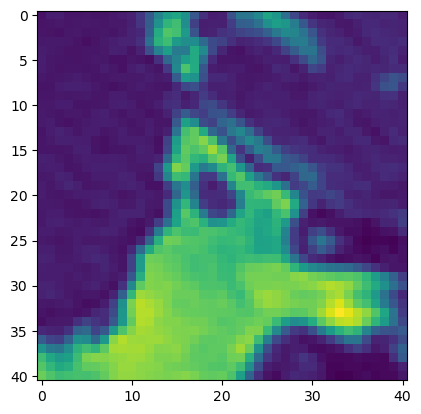

In [2492]:
crop_scan_original = full_scan[centroid[0]-crop_size:centroid[0]+crop_size+1, centroid[1]-crop_size:centroid[1]+crop_size+1, centroid[2]-crop_size:centroid[2]+ crop_size+1]

plt.imshow(crop_scan_original[:,20,:])

In [2493]:
full_scan.shape

(256, 256, 251)

(-0.5, 255.5, 255.5, -0.5)

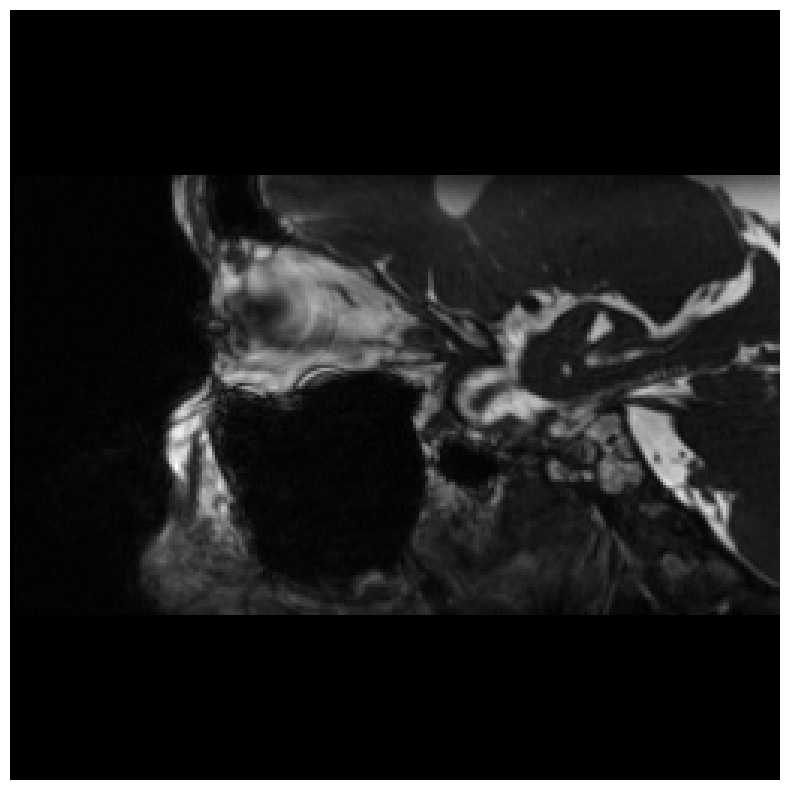

In [2494]:
plt.figure(figsize=(10,10));
plt.imshow(full_scan[:,:,centroid[2]],'gray')
plt.axis('off')

[INFO] Maximum value is 1032.0
[INFO] New maximum value is 255


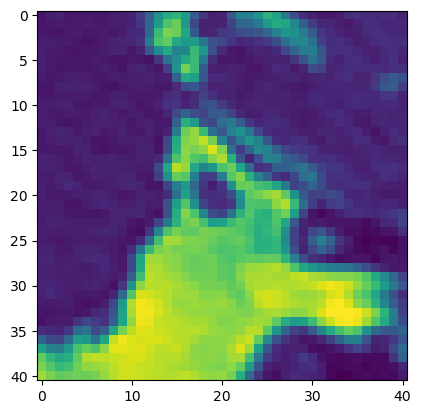

In [2495]:
# saturate top 15% of values and normalize to 255
print(f"[INFO] Maximum value is {np.amax(crop_scan_original)}")
cutoff = (np.amax(crop_scan_original))*0.85
#normalizing the value
crop_scan_mask = crop_scan_original > cutoff #> 900
crop_scan_original[crop_scan_mask] = cutoff #900
scale_value = 255/(np.amax(crop_scan_original))
crop_scan = np.array(scale_value*crop_scan_original, dtype = np.uint16)

print(f"[INFO] New maximum value is {np.amax(crop_scan)}")
plt.imshow(crop_scan[:,20,:])


In [2496]:
#array to save segmentation
segmentation_y = np.zeros_like(crop_scan)
print(f"[INFO] Moving in the y direction")

segmentation_y[crop_size,crop_size,crop_size] = 1
#filling center of segmentation with 1 (meaning true)
print(f"[INFO] Acceptable area change for cross-section is {area_percent}") #150%

[INFO] Moving in the y direction
[INFO] Acceptable area change for cross-section is 3


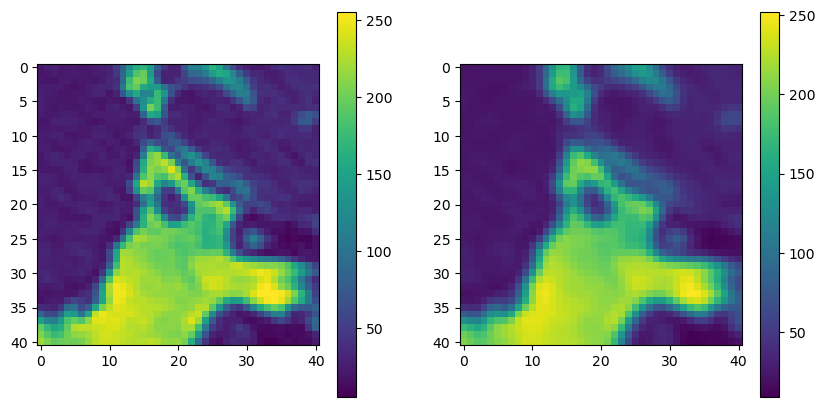

In [2497]:
#pull out the initial array fo r a given z
arr1_og = crop_scan[:, 20, :]

arr1_blurred = cv2.GaussianBlur(arr1_og, (3,3), 0)
#calculate scale value to scale to uint8 scale
dat = np.array(arr1_blurred, dtype = np.uint8)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(arr1_og)
plt.colorbar()
plt.subplot(122)
plt.imshow(dat)
plt.colorbar()

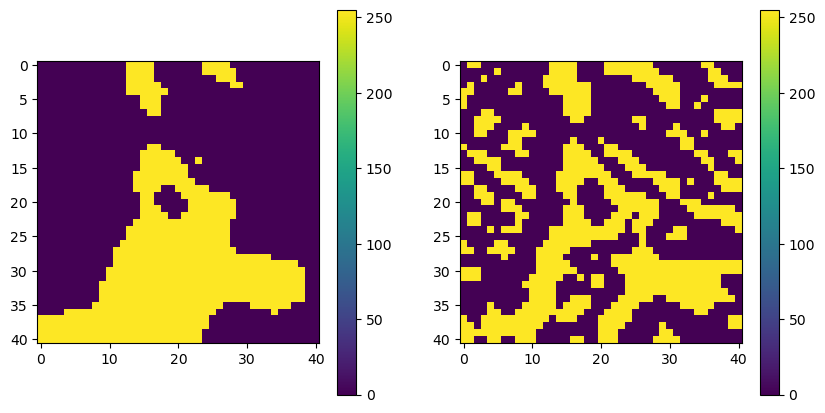

In [2520]:
#blur to remove noise
arr1_binary_all = cv2.adaptiveThreshold(dat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 0)
# th = (dat.max() - dat.min())/2 + dat.min()
centerPix = dat[crop_size,crop_size]
th = (np.percentile(dat.flatten(),95) - centerPix)/3 + centerPix
_, arr1_binary_thresh = cv2.threshold(dat, th, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(arr1_binary_thresh)
plt.colorbar()
plt.subplot(122)
plt.imshow(arr1_binary_all)
plt.colorbar()

(-0.5, 40.5, 40.5, -0.5)

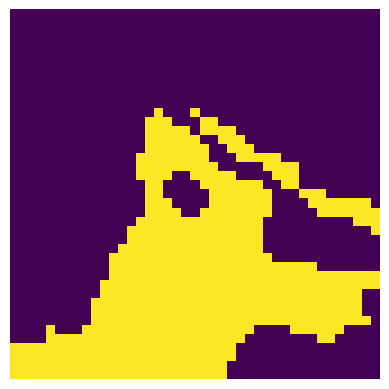

In [2521]:
arr1_binary_all = arr1_binary_all | arr1_binary_thresh

init_guess = np.zeros_like(arr1_binary_all)
init_guess[17:23,17:23] = 1

arr1_binary = remove_background(arr1_binary_all, init_guess)
arr1_binary = arr1_binary.astype(np.uint8)

plt.imshow(arr1_binary)
# plt.colorbar()
plt.axis('off')

(-0.5, 40.5, 40.5, -0.5)

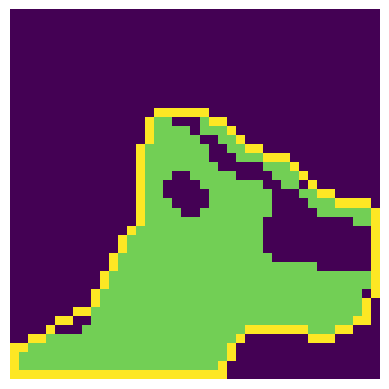

In [2522]:
arr1 = hull_and_kmeans(arr1_binary)
#find and print the contours and hulls given a binary 2D array
#plt.imshow(arr1)
if arr1[crop_size, crop_size] > 200:
    arr1[crop_size, crop_size] = 14
# if arr1[crop_size+1, crop_size] > 200:
#     arr1[crop_size+1, crop_size] = 14
# if arr1[crop_size-1, crop_size] > 200:
#     arr1[crop_size-1, crop_size] = 14
# if arr1[crop_size, crop_size+1] > 200:
#     arr1[crop_size, crop_size+1] = 14
# if arr1[crop_size, crop_size-1] > 200:
#     arr1[crop_size, crop_size-1] = 14

arr1[arr1 == 255] = 200

plt.imshow(arr1)
plt.axis('off')
# plt.colorbar()

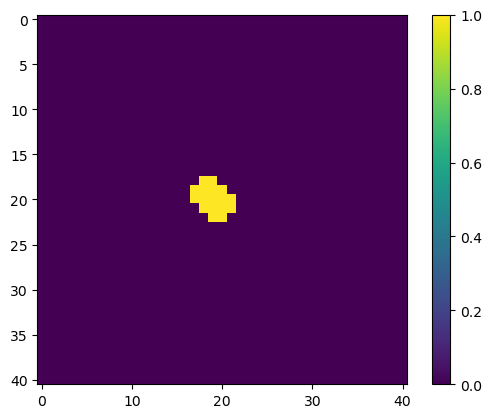

In [2523]:
#flood fill from teh 2D centroid
arr1_flooded = flood_fill(arr1, (crop_size, crop_size), 1, connectivity = 1, tolerance = upper_limit - np.ceil(arr1[crop_size, crop_size]))
arr1_flooded = arr1_flooded == 1

plt.imshow(arr1_flooded)
plt.colorbar()

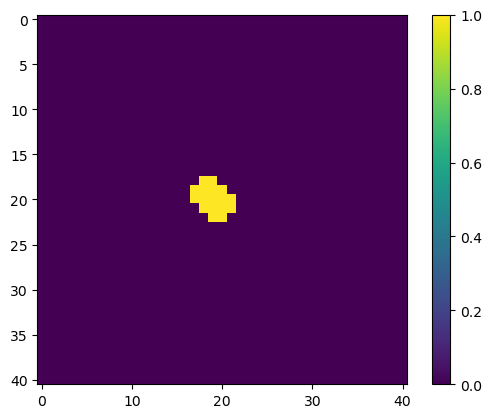

In [2524]:
arr1_old = arr1_flooded.copy();
tmp = np.zeros((crop,crop));
for i in range(arr1_flooded.shape[0]):
    for j in range(arr1_flooded.shape[1]):
        if arr1_old[i,j] == True:
            if i > 0 and arr1[i-1,j] == 254 and dat[i-1,j] < 130:
                tmp[i-1,j] = tmp[i-1,j] + 1;
            if j > 0 and arr1[i,j-1] == 254 and dat[i,j-1] < 130:
                tmp[i,j-1] = tmp[i,j-1] + 1;
            if i < arr1_flooded.shape[0]-1 and arr1[i+1,j] == 254 and dat[i+1,j] < 130:
                tmp[i+1,j] = tmp[i+1,j] + 1;
            if j < arr1_flooded.shape[1]-1 and arr1[i,j+1] == 254 and dat[i,j+1] < 130:
                tmp[i,j+1] = tmp[i,j+1] + 1;
            if i > 0 and j > 0 and arr1[i-1,j-1] == 254 and dat[i-1,j-1] < 130:
                tmp[i-1,j-1] = tmp[i-1,j-1] + 1;
            if i > 0 and j < arr1_flooded.shape[1]-1 and arr1[i-1,j+1] == 254 and dat[i-1,j+1] < 130:
                tmp[i-1,j+1] = tmp[i-1,j+1] + 1;
            if i < arr1_flooded.shape[0]-1 and j > 0 and arr1[i+1,j-1] == 254 and dat[i+1,j-1] < 130:
                tmp[i+1,j-1] = tmp[i+1,j-1] + 1;
            if  i < arr1_flooded.shape[0]-1 and j < arr1_flooded.shape[1]-1 and arr1[i+1,j+1] == 254 and dat[i+1,j+1] < 130:
                tmp[i+1,j+1] = tmp[i+1,j+1] + 1;
arr1_flooded = arr1_flooded | (tmp > 3);

plt.imshow(arr1_flooded)
plt.colorbar()

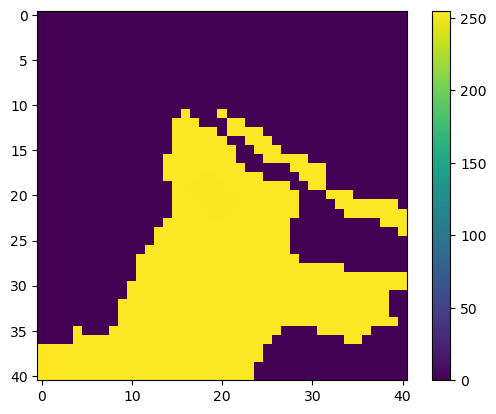

In [2525]:
arr3 = arr1_binary
arr3[arr1_flooded] = 254

plt.imshow(arr3)
plt.colorbar()

(-0.5, 40.5, 40.5, -0.5)

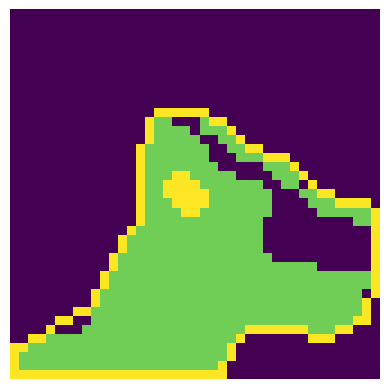

In [2526]:
arr1[arr1_flooded] = 255

plt.imshow(arr1)
plt.axis('off')

[INFO] Initialization area is 17
Calculated area for next loop is 0


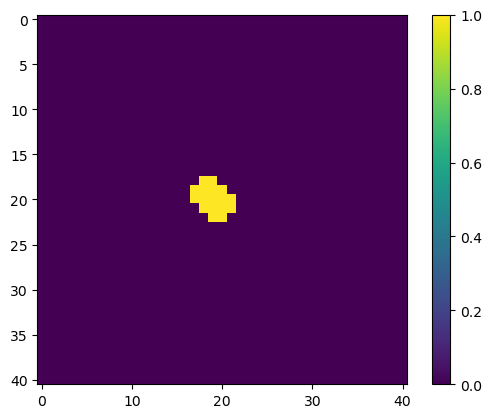

In [2527]:
arr1_dilated = cv2.dilate(np.asarray(arr1_flooded*255, dtype="uint8"), np.ones((2,2)))
print(f"[INFO] Initialization area is {sum(sum(arr1_flooded))}")
out, flag = loop(arr3, sum(sum(arr1_flooded)), arr1_dilated == 255, arr1_flooded)
arr1_flooded = out | arr1_flooded

plt.imshow(arr1_flooded)
plt.colorbar()

In [2528]:
#calculate area, store area as baseline for later comparison
area_at_centroid = np.sum(np.sum(arr1_flooded))
major_axis_a = np.sum(arr1_flooded,axis = 0)[crop_size]
major_axis_b = np.sum(arr1_flooded,axis=1)[crop_size]
ellipse_area = 3.1415926 * major_axis_a * major_axis_b
#print(f"[INFO] Axis are {major_axis_a} and {major_axis_b} and area is {ellipse_area}")
#print(f"Calculated area at centroid is {area_at_centroid}")
segmentation_y[:, crop_size, :] = arr1_flooded

In [2529]:
press_forward_y(arr1_flooded, crop_size, area_at_centroid)

Calculated area for next loop is 18
[FORWARD] Calculated area for next forwards step is 18
Calculated area for next loop is 17
[FORWARD] Calculated area for next forwards step is 17
Calculated area for next loop is 0
Original area size is 0
Calculated area for next loop is 18
Calculated area for next loop is 4
Filled in the gaps with area 22 and allowable change is 51 at 23
[FORWARD] Calculated area for next forwards step is 22
Calculated area for next loop is 0
Original area size is 0
Calculated area for next loop is 10
Calculated area for next loop is 2
Filled in the gaps with area 12 and allowable change is 66 at 24
[FORWARD] Calculated area for next forwards step is 12
Calculated area for next loop is 0
Original area size is 0
Calculated area for next loop is 5
Calculated area for next loop is 0
Filled in the gaps with area 5 and allowable change is 36 at 25
[FORWARD] Calculated area for next forwards step is 5
Calculated area for next loop is 0
Original area size is 0
Calculated a

/var/folders/kg/kdvbybgj03g64srr848x9b500000gn/T/ipykernel_97224/3875800791.py:99: RuntimeWarning: invalid value encountered in long_scalars
  acceptable_box_change = (width < crop*.6 and height < crop*.6) and (((((width-width_prev)/width_prev) < 1.5 and (height-height_prev)/height_prev<0.66)) or (((width-width_prev)/width_prev <1.5 and (height-height_prev)/height_prev) < 0.66))


In [2530]:
press_backward_y(arr1_flooded, crop_size, area_at_centroid)

Calculated area for next loop is 14
[BACK] Calculated area for next backwards step is 14
Previous area was 17
Calculated area for next loop is 14
[BACK] Calculated area for next backwards step is 14
Previous area was 14
Calculated area for next loop is 13
[BACK] Calculated area for next backwards step is 13
Previous area was 14
Calculated area for next loop is 12
[BACK] Calculated area for next backwards step is 12
Previous area was 13
Calculated area for next loop is 12
[BACK] Calculated area for next backwards step is 12
Previous area was 12
Calculated area for next loop is 12
[BACK] Calculated area for next backwards step is 12
Previous area was 12
Calculated area for next loop is 0
Original area size is 0
Calculated area for next loop is 18
Calculated area for next loop is 3
Filled in the gaps with area 21 and allowable change is 36 at 13
[BACK] Calculated area for next backwards step is 21
Previous area was 12
Calculated area for next loop is 0
Original area size is 0
Calculated a

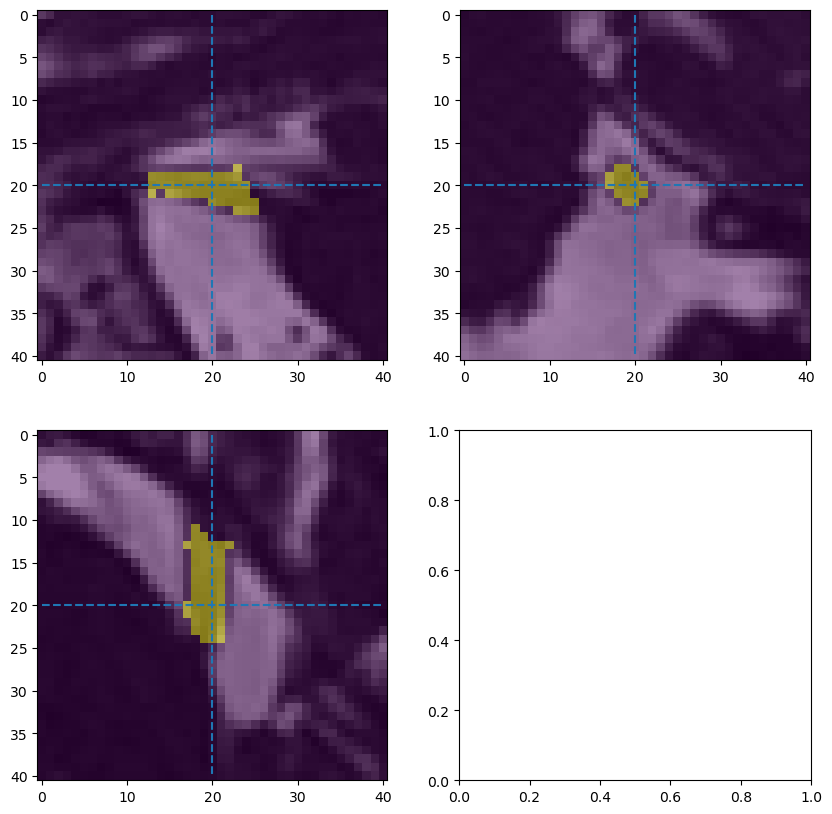

In [2531]:
fig = plt.figure(figsize=(10,10))
_, axes = fig.subplots(2,2)
# plt.subplots_adjust(left=0.25, bottom=0.25)
s0 = crop_size
c0 = crop_size
a0 = crop_size


coord = np.array([s0,c0,a0])
gridlinestyles = 'dashed'

plt.subplot(221)
im_s = plt.imshow(crop_scan[:,:,s0], cmap = plt.cm.gray)#, vmin=lb, vmax=ub)
seg_s = plt.imshow(segmentation_y[:,:,s0], alpha = 0.5,vmin = 0, vmax = 1)
al_s = plt.hlines(a0,xmin=0,xmax=crop_scan.shape[1]-1,linestyles=gridlinestyles)
cl_s = plt.vlines(c0,ymin=0,ymax=crop_scan.shape[0]-1,linestyles=gridlinestyles)
plt.subplot(222)
im_c = plt.imshow(crop_scan[:,c0,:], cmap = plt.cm.gray)#, vmin=lb, vmax=ub)
seg_c = plt.imshow(segmentation_y[:,c0,:], alpha = 0.5,vmin = 0, vmax = 1)
al_c = plt.hlines(a0,xmin=0,xmax=crop_scan.shape[2]-1,linestyles=gridlinestyles)
sl_c = plt.vlines(s0,ymin=0,ymax=crop_scan.shape[0]-1,linestyles=gridlinestyles)
plt.subplot(223)
im_a = plt.imshow(crop_scan[a0,:,:], cmap = plt.cm.gray)#, vmin=lb, vmax=ub)
seg_a = plt.imshow(segmentation_y[a0,:,:], alpha = 0.5,vmin = 0, vmax = 1)
cl_a = plt.hlines(c0,xmin=0,xmax=crop_scan.shape[2]-1,linestyles=gridlinestyles)
sl_a = plt.vlines(s0,ymin=0,ymax=crop_scan.shape[1]-1,linestyles=gridlinestyles)

In [2532]:
# full_scan = full_scan.transpose((0,2,1))
# centroid = centroid[[0,2,1]]
# segmentation_y = segmentation_y.transpose((0,2,1))

full_scan.shape

(256, 256, 251)

In [2533]:
# if full_scan.shape[2] > 1.5 * full_scan.shape[0]:
# segmentation = np.array(np.zeros_like(full_scan[:,:,:full_scan.shape[2]//2]), dtype=np.uint8)
# else:
segmentation = np.array(np.zeros_like(full_scan), dtype=np.uint8)

segmentation[centroid[0]-crop_size:centroid[0]+crop_size+1, centroid[1]-crop_size:centroid[1]+crop_size+1, centroid[2]-crop_size:centroid[2]+ crop_size+1] = np.array(segmentation_y.copy(),dtype=np.uint8)


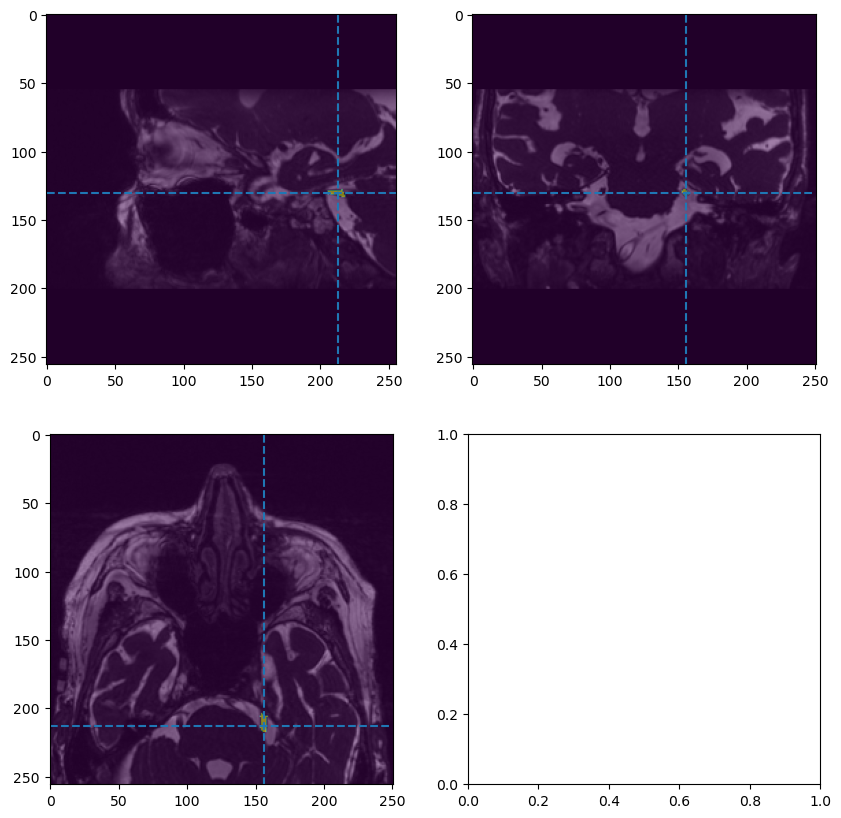

In [2534]:
fig = plt.figure(figsize=(10,10))
_, axes = fig.subplots(2,2)
# plt.subplots_adjust(left=0.25, bottom=0.25)
s0 = centroid[2]
c0 = centroid[1]
a0 = centroid[0]


coord = np.array([s0,c0,a0])
gridlinestyles = 'dashed'

plt.subplot(221)
im_s = plt.imshow(full_scan[:,:,s0], cmap = plt.cm.gray)#, vmin=lb, vmax=ub)
seg_s = plt.imshow(segmentation[:,:,s0], alpha = 0.5,vmin = 0, vmax = 1)
al_s = plt.hlines(a0,xmin=0,xmax=full_scan.shape[1]-1,linestyles=gridlinestyles)
cl_s = plt.vlines(c0,ymin=0,ymax=full_scan.shape[0]-1,linestyles=gridlinestyles)
plt.subplot(222)
im_c = plt.imshow(full_scan[:,c0,:], cmap = plt.cm.gray)#, vmin=lb, vmax=ub)
seg_c = plt.imshow(segmentation[:,c0,:], alpha = 0.5,vmin = 0, vmax = 1)
al_c = plt.hlines(a0,xmin=0,xmax=full_scan.shape[2]-1,linestyles=gridlinestyles)
sl_c = plt.vlines(s0,ymin=0,ymax=full_scan.shape[0]-1,linestyles=gridlinestyles)
plt.subplot(223)
im_a = plt.imshow(full_scan[a0,:,:], cmap = plt.cm.gray)#, vmin=lb, vmax=ub)
seg_a = plt.imshow(segmentation[a0,:,:], alpha = 0.5,vmin = 0, vmax = 1)
cl_a = plt.hlines(c0,xmin=0,xmax=full_scan.shape[2]-1,linestyles=gridlinestyles)
sl_a = plt.vlines(s0,ymin=0,ymax=full_scan.shape[1]-1,linestyles=gridlinestyles)

In [2535]:
# itk_image = sitk.GetImageFromArray(np.transpose(np.flip(segmentation,2),[2,0,1]));
itk_image = sitk.GetImageFromArray(np.transpose(segmentation,[2,0,1]));

# itk_image = sitk.GetImageFromArray(np.transpose(np.flip(segmentation,2),[0,1,2]));
# itk_image = sitk.GetImageFromArray(np.transpose(segmentation,[0,1,2]));

itk_image.SetOrigin(og_image.GetOrigin())
itk_image.SetDirection(og_image.GetDirection())
itk_image.SetSpacing(og_image.GetSpacing())
# itk_image.SetSize(og_image.GetSize())
print(og_image.GetSize())
print(full_scan.shape)

itk_image = sitk.Cast(itk_image, sitk.sitkUInt8);

# itk_image.CopyInformation(og_image)1
print(itk_image.GetSize())

sitk.WriteImage(itk_image, directory + f'/segmentations/{MRN}_NV_SEG.nrrd');

(256, 256, 251)
(256, 256, 251)
(256, 256, 251)


In [2536]:
MRN

'58317085'

## Graveyard

In [ ]:
th1 = (dat.max() - dat.min())/3 + dat.min()
th2 = (dat.max() - dat.min())/3*2 + dat.min()

dat2 = dat.copy()
dat2[dat2 > th2] = th2
dat2[dat2 < th1] = th1

plt.imshow(dat2)
plt.colorbar()

In [ ]:
data = dat2.astype(float)
diffImg = np.abs(data[1:-2,1:-2]-data[2:-1,1:-2]) + \
          np.abs(data[1:-2,1:-2]-data[2:-1,2:-1]) + \
          np.abs(data[1:-2,1:-2]-data[1:-2,2:-1]) + \
          np.abs(data[1:-2,1:-2]-data[0:-3,2:-1]) + \
          np.abs(data[1:-2,1:-2]-data[0:-3,1:-2]) + \
          np.abs(data[1:-2,1:-2]-data[0:-3,0:-3]) + \
          np.abs(data[1:-2,1:-2]-data[1:-2,0:-3]) + \
          np.abs(data[1:-2,1:-2]-data[2:-1,0:-3])

plt.imshow(diffImg)
plt.colorbar()

In [ ]:
arr_prev_flooded = arr1_flooded.copy()
y = crop_size
area_prev = area_at_centroid

In [ ]:
arr2_og = crop_scan[:, y-1, :]
#pull out the  coronal plane
arr2_og = np.array(arr2_og, dtype=np.uint16)
#convert data types

arr2_blurred = cv2.GaussianBlur(arr2_og, (3,3), 0)

dat = np.array(arr2_blurred, dtype = np.uint8) #can switch to arr2_blurred or arr2_og
#scale to uint8

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(arr2_og)
plt.colorbar()
plt.subplot(122)
plt.imshow(dat)
plt.colorbar()

In [ ]:
#loop through all x and y spots and compare back to the previous z to see hwere they overlay
arr2_flooded = np.zeros_like(arr2_og) == 1
# out, flag = loop(arr2_og, area_prev, arr_prev_flooded, arr_prev_flooded)
arr2_binary = cv2.adaptiveThreshold(dat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
th = (dat.max() - dat.min())/2 + dat.min()
_, arr2_binary_thresh = cv2.threshold(dat, th, 255, cv2.THRESH_BINARY)

arr2_binary = remove_background(arr2_binary | arr2_binary_thresh, arr_prev_flooded)

plt.imshow(arr2_binary)

In [ ]:
out, flag = loop(arr2_binary, area_prev, arr_prev_flooded, arr_prev_flooded)

arr2_flooded = arr2_flooded | out
arr2_area = sum(sum(arr2_flooded.astype(int)))

arr4_flooded = arr2_flooded.copy()
arr4_area = sum(sum(arr4_flooded))

print(flag)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(arr2_flooded)
plt.colorbar()
plt.subplot(122)
plt.imshow(out)
plt.colorbar()

In [ ]:
# flag == True

print(f"Original area size is {arr2_area}")
arr2_flooded = np.zeros_like(arr2_og) == 1

arr2 = hull_and_kmeans(arr2_binary)

plt.imshow(arr2)

In [ ]:
#cv2.waitKey(0)
out, flag = loop(arr2, area_prev, arr_prev_flooded, arr_prev_flooded)
arr2_flooded = out | arr2_flooded

if debug_plots or debug_plots_back:
    print('arr2_flooded')
    plt.imshow(arr2_flooded)
    plt.show();

arr2_old = arr2_flooded.copy();
tmp = np.zeros((crop,crop));

seg_mean = np.mean(arr2_og[arr2_flooded])
seg_sd = np.std(arr2_og[arr2_flooded])

for i in range(arr2_flooded.shape[0]):
    for j in range(arr2_flooded.shape[1]):
        if arr2_old[i,j] == True:
            if i > 0 and arr2[i-1,j] == 254 and arr2_og[i-1,j] - seg_mean < seg_sd:
                tmp[i-1,j] = tmp[i-1,j] + 1;
            if j > 0 and arr2[i,j-1] == 254 and arr2_og[i,j-1] - seg_mean < seg_sd:
                tmp[i,j-1] = tmp[i,j-1] + 1;
            if i < arr2_flooded.shape[0]-1 and arr2[i+1,j] == 254 and arr2_og[i+1,j] - seg_mean < seg_sd:
                tmp[i+1,j] = tmp[i+1,j] + 1;
            if j < arr2_flooded.shape[1]-1 and arr2[i,j+1] == 254 and arr2_og[i,j+1] - seg_mean < seg_sd:
                tmp[i,j+1] = tmp[i,j+1] + 1;
            if i > 0 and j > 0 and arr2[i-1,j-1] == 254 and arr2_og[i-1,j-1] - seg_mean < seg_sd:
                tmp[i-1,j-1] = tmp[i-1,j-1] + 1;
            if i > 0 and j < arr2_flooded.shape[1]-1 and arr2[i-1,j+1] == 254 and arr2_og[i-1,j+1] - seg_mean < seg_sd:
                tmp[i-1,j+1] = tmp[i-1,j+1] + 1;
            if i < arr2_flooded.shape[0]-1 and j > 0 and arr2[i+1,j-1] == 254 and arr2_og[i+1,j-1] - seg_mean < seg_sd:
                tmp[i+1,j-1] = tmp[i+1,j-1] + 1;
            if  i < arr2_flooded.shape[0]-1 and j < arr2_flooded.shape[1]-1 and arr2[i+1,j+1] == 254 and arr2_og[i+1,j+1] - seg_mean < seg_sd:
                tmp[i+1,j+1] = tmp[i+1,j+1] + 1;
arr2_flooded = arr2_flooded | (tmp > 3);

if debug_plots or debug_plots_back:
    print('tmp');
    plt.imshow(tmp);
    plt.show();
    print('arr2_flooded adj')
    plt.imshow(arr2_flooded)
    plt.show();

arr3_binary_all = cv2.adaptiveThreshold(dat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
_, arr3_binary_thresh = cv2.threshold(dat, 130, 255, cv2.THRESH_BINARY)
arr3_binary_all = arr3_binary_all | arr3_binary_thresh

if debug_plots or debug_plots_back:
    print('arr3_binary_all')
    plt.imshow(arr3_binary_all)
    plt.show();

#create the new binary
mask = remove_background(arr3_binary_all, arr_prev_flooded)
arr3 = mask.astype('uint8')
arr3[arr2_flooded] = 254
#plt.imshow(arr3)

if debug_plots or debug_plots_back:
    print('arr3')
    plt.imshow(arr3)
    plt.show();

#arr_to_dilate = cv2.threshold(np.asarray(arr1_flooded*255), 50, 255, cv2.THRESH_BINARY)
arr2_dilated = cv2.dilate(np.asarray(arr2_flooded*255, dtype="uint8"), np.ones((3,3)))
#plt.imshow(arr3)

out, flag = loop(arr3, area_prev, arr2_dilated == 255, arr_prev_flooded)
check_arr2_flooded = out | arr2_flooded

if debug_plots or debug_plots_back:
    print('check_arr2_flooded')
    plt.imshow(check_arr2_flooded)
    plt.show();

if sum(sum(check_arr2_flooded)) < area_percent*area_prev:
    print(f"Filled in the gaps with area {sum(sum(check_arr2_flooded))} and allowable change is {area_percent*area_prev} at {y-1}")
    arr2_flooded = out | arr2_flooded
else:
    print(f"Did not fill in the gaps with area {sum(sum(check_arr2_flooded))} and allowable change is {area_percent*area_prev} at {y-1}")

In [ ]:
arr2_area = sum(sum(arr2_flooded.astype(int)))
print(f"[BACK] Calculated area for next backwards step is {arr2_area}")
print(f"Previous area was {area_prev}")

(arr2_area <area_percent*area_prev or arr2_area < 100) and y - 2 >= 0 and arr2_area > 2


In [ ]:
segmentation_y[:, y-1, :] = arr2_flooded.astype(int)


In [ ]:
arr_prev_flooded = arr2_flooded
y = y-1
area_prev = arr2_area